数据集大小：1000


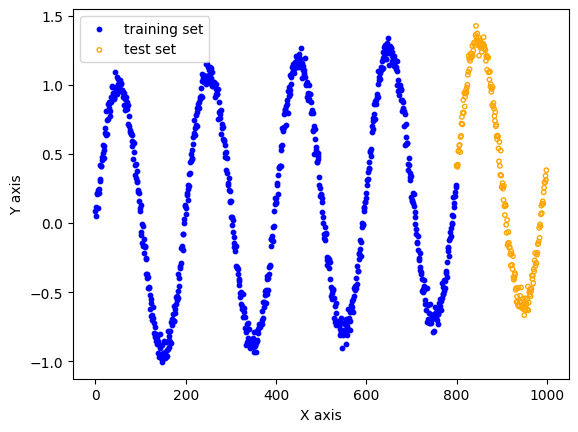

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

# 导入数据集
data = np.loadtxt('sindata_1000.csv', delimiter=',')
num_data = len(data)
split = int(0.8 * num_data)
print(f'数据集大小：{num_data}')
# 数据集可视化
plt.figure()
plt.scatter(np.arange(split), data[:split], color='blue', 
    s=10, label='training set')
plt.scatter(np.arange(split, num_data), data[split:], color='none', 
    edgecolor='orange', s=10, label='test set')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()
# 分割数据集
train_data = np.array(data[:split])
test_data = np.array(data[split:])

In [81]:
# 输入序列长度
seq_len = 20
# 处理训练数据，把切分序列后多余的部分去掉
train_num = len(train_data) // (seq_len + 1) * (seq_len + 1)
train_data = np.array(train_data[:train_num]).reshape(-1, seq_len + 1, 1)
np.random.seed(0)
torch.manual_seed(0)

x_train = train_data[:, :seq_len] # 形状为(num_data, seq_len, input_size)
y_train = train_data[:, 1: seq_len + 1]
print(f'训练序列数：{len(x_train)}')

# 转为PyTorch张量
x_train = torch.from_numpy(x_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
x_test = torch.from_numpy(test_data[:-1]).to(torch.float32)
y_test = torch.from_numpy(test_data[1:]).to(torch.float32)

训练序列数：38


In [82]:
class GRU(nn.Module):
    # 包含PyTorch的GRU和拼接的MLP
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        # GRU模块
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size) 
        # 将中间变量映射到预测输出的MLP
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # 前向传播
        # x的维度为(batch_size, seq_len, input_size)
        # GRU模块接受的输入为(seq_len, batch_size, input_size)
        # 因此需要对x进行变换
        # transpose函数可以交换x的坐标轴
        # out的维度是(seq_len, batch_size, hidden_size)
        out, hidden = self.gru(torch.transpose(x, 0, 1), hidden) 
        # 取序列最后的中间变量输入给全连接层
        out = self.linear(out.view(-1, hidden_size))
        return out, hidden

In [83]:
# 超参数
input_size = 1 # 输入维度
output_size = 1 # 输出维度
hidden_size = 16 # 中间变量维度
learning_rate = 5e-4

# 初始化网络
gru = GRU(input_size, output_size, hidden_size)
gru_optim = torch.optim.Adam(gru.parameters(), lr=learning_rate)

# GRU测试函数，x和hidden分别是初始的输入和中间变量
def test_gru(gru, x, hidden, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        gru_pred, hidden = gru(inp, hidden)
        pred.append(gru_pred.detach())
        inp = gru_pred
    return torch.concat(pred).reshape(-1)

In [84]:
# MLP的超参数
hidden_1 = 32
hidden_2 = 16
mlp = nn.Sequential(
    nn.Linear(input_size, hidden_1),
    nn.ReLU(),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, output_size)
)
mlp_optim = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# MLP测试函数，相比于GRU少了中间变量
def test_mlp(mlp, x, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        mlp_pred = mlp(inp)
        pred.append(mlp_pred.detach())
        inp = mlp_pred
    return torch.concat(pred).reshape(-1)

In [85]:
max_epoch = 150
criterion = nn.functional.mse_loss
hidden = None # GRU的中间变量

# 训练损失
gru_losses = []
mlp_losses = []
gru_test_losses = []
mlp_test_losses = []
# 开始训练
with tqdm(range(max_epoch)) as pbar:
    for epoch in pbar:
        st = 0
        gru_loss = 0.0
        mlp_loss = 0.0
        # 随机梯度下降
        for X, y in zip(x_train, y_train):
            # 更新GRU模型
            # 我们不需要通过梯度回传更新中间变量
            # 因此将其从有梯度的部分分离出来
            if hidden is not None:
                hidden.detach_()
            gru_pred, hidden = gru(X[None, ...], hidden)
            gru_train_loss = criterion(gru_pred.view(y.shape), y)
            gru_optim.zero_grad()
            gru_train_loss.backward()
            gru_optim.step()
            gru_loss += gru_train_loss.item()
            # 更新MLP模型
            # 需要对输入的维度进行调整，变成(seq_len, input_size)的形式
            mlp_pred = mlp(X.view(-1, input_size))
            mlp_train_loss = criterion(mlp_pred.view(y.shape), y)
            mlp_optim.zero_grad()
            mlp_train_loss.backward()
            mlp_optim.step()
            mlp_loss += mlp_train_loss.item()
        
        gru_loss /= len(x_train)
        mlp_loss /= len(x_train)
        gru_losses.append(gru_loss)
        mlp_losses.append(mlp_loss)
        
        # 训练和测试时的中间变量序列长度不同，训练时为seq_len，测试时为1
        gru_pred = test_gru(gru, x_test[0], hidden[:, -1], len(y_test))
        mlp_pred = test_mlp(mlp, x_test[0], len(y_test))
        gru_test_loss = criterion(gru_pred, y_test).item()
        mlp_test_loss = criterion(mlp_pred, y_test).item()
        gru_test_losses.append(gru_test_loss)
        mlp_test_losses.append(mlp_test_loss)
        
        pbar.set_postfix({
            'Epoch': epoch,
            'GRU loss': f'{gru_loss:.4f}',
            'MLP loss': f'{mlp_loss:.4f}',
            'GRU test loss': f'{gru_test_loss:.4f}',
            'MLP test loss': f'{mlp_test_loss:.4f}'
        })

100%|██████████| 150/150 [00:37<00:00,  4.05it/s, Epoch=149, GRU loss=0.0034, MLP loss=0.0056, GRU test loss=0.0392, MLP test loss=1.1252]


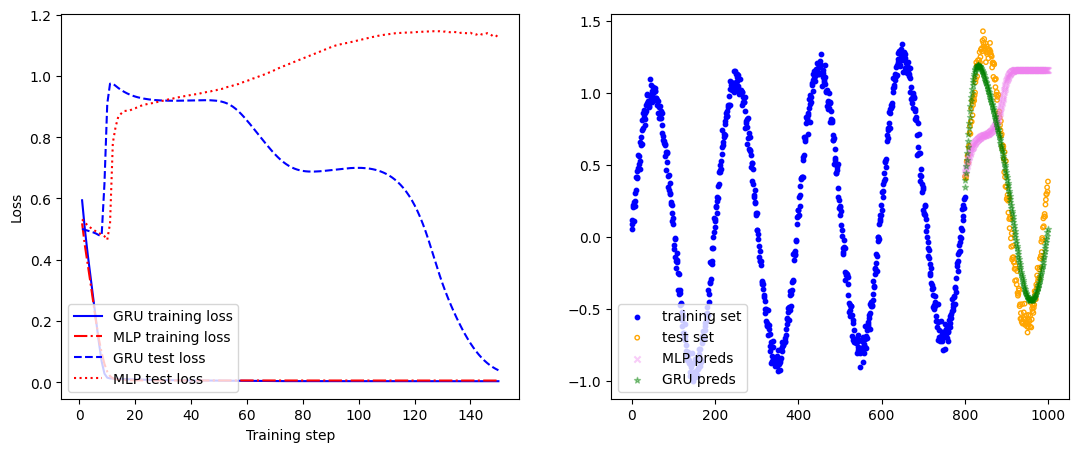

In [86]:
# 最终测试结果
gru_preds = test_gru(gru, x_test[0], hidden[:, -1], len(y_test)).numpy()
mlp_preds = test_mlp(mlp, x_test[0], len(y_test)).numpy()

plt.figure(figsize=(13, 5))

# 绘制训练曲线
plt.subplot(121)
x_plot = np.arange(len(gru_losses)) + 1
plt.plot(x_plot, gru_losses, color='blue', 
    label='GRU training loss')
plt.plot(x_plot, mlp_losses, color='red', 
    ls='-.', label='MLP training loss')
plt.plot(x_plot, gru_test_losses, color='blue', 
    ls='--', label='GRU test loss')
plt.plot(x_plot, mlp_test_losses, color='red', 
    ls=':', label='MLP test loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.legend(loc='lower left')

# 绘制真实数据与模型预测值的图像
plt.subplot(122)
plt.scatter(np.arange(split), data[:split], color='blue', 
    s=10, label='training set')
plt.scatter(np.arange(split, num_data), data[split:], color='none', 
    edgecolor='orange', s=10, label='test set')
plt.scatter(np.arange(split, num_data - 1), mlp_preds, color='violet', 
    marker='x', alpha=0.4, s=20, label='MLP preds')
plt.scatter(np.arange(split, num_data - 1), gru_preds, color='green', 
    marker='*', alpha=0.4, s=20, label='GRU preds')
plt.legend(loc='lower left')
plt.savefig('output_20_0.png')
plt.savefig('output_20_0.pdf')
plt.show()